In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error as RMSE
from math import sqrt
import seaborn as sns

In [2]:
parser = lambda date: pd.to_datetime(date, format='%d.%m.%Y')

tr = pd.read_csv('sales_train_v2.csv', parse_dates=['date'], date_parser=parser)
ts = pd.read_csv('test.csv', index_col=0)

item_categories = pd.read_csv('item_categories.csv',index_col=1)
items = pd.read_csv('items.csv',index_col=1)
shops = pd.read_csv('shops.csv',index_col=1)
sample_submission = pd.read_csv('sample_submission.csv',index_col=0)


print("Loaded")

Loaded


In [3]:
train = tr
test = ts

In [4]:
print('train:',train.shape)
print(' test:',test.shape)

train: (2935849, 6)
 test: (214200, 2)


In [5]:
#each date_block_num is a month
train[train['date_block_num']==1].head()
train[train['date_block_num']==2].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
224303,2013-03-03,2,5,20175,849.0,1.0
224304,2013-03-06,2,5,20083,149.0,1.0
224305,2013-03-02,2,2,31,698.5,1.0
224306,2013-03-17,2,41,2437,699.5,1.0
224307,2013-03-02,2,41,2417,349.0,1.0


In [6]:
shops.head(10) # shop id and name - not interesting 
item_categories.head() # item category id and name not interesting 
items.head() # item_id item name and item category id . can be interesting !!

,item_name,item_category_id
item_id,,
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,40
1,!ABBYY FineReader 12 Professional Edition Full...,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,40
4,***КОРОБКА (СТЕКЛО) D,40


In [7]:
print(train.head())
print("")
print(test.head())
print(" ")
print(sample_submission.head())

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0 2013-01-02               0       59    22154      999.00           1.0
1 2013-01-03               0       25     2552      899.00           1.0
2 2013-01-05               0       25     2552      899.00          -1.0
3 2013-01-06               0       25     2554     1709.05           1.0
4 2013-01-15               0       25     2555     1099.00           1.0

    shop_id  item_id
ID                  
0         5     5037
1         5     5320
2         5     5233
3         5     5232
4         5     5268
 
    item_cnt_month
ID                
0              0.5
1              0.5
2              0.5
3              0.5
4              0.5


In [8]:
test['date_block_num'] = 34

test = test.reindex(columns=['date_block_num', 'shop_id', 'item_id'])

test.head()

,date_block_num,shop_id,item_id
ID,,,
0,34,5,5037
1,34,5,5320
2,34,5,5233
3,34,5,5232
4,34,5,5268


In [9]:
# simple model 
# drop date ,price 
#group by data block 

train = pd.DataFrame(train.groupby(['date_block_num','shop_id','item_id'])['item_cnt_day'].sum().reset_index())
train.sort_values(by=['date_block_num','shop_id','item_id'])
train = train.rename(columns={'item_cnt_day':'item_cnt_month'})
train.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [10]:
#train test split

X = train[['date_block_num','shop_id','item_id']]
y = train['item_cnt_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [11]:
#predict 

regr = linear_model.LinearRegression()

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

score = sqrt(RMSE(y_test,y_pred))

print(score)

8.514029459134909


In [12]:
## seperate date by year and month and not by data_block

In [13]:
#diffrent model 
#to test add date ,maybe  match category id
# from train delete data block num , item price , maybe match categoryid

train = tr
test = ts

train = train.drop(['date_block_num','item_price'],axis =1)
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train = train.drop('date',axis =1)

train.head()

,shop_id,item_id,item_cnt_day,month,year
0,59,22154,1.0,1,2013
1,25,2552,1.0,1,2013
2,25,2552,-1.0,1,2013
3,25,2554,1.0,1,2013
4,25,2555,1.0,1,2013


In [14]:
train = pd.DataFrame(train.groupby(['year','month','shop_id','item_id'])['item_cnt_day'].sum().reset_index())
train.sort_values(by=['year','month','shop_id','item_id'])
train = train.rename(columns={'item_cnt_day':'item_cnt_month'})
train.head()

,year,month,shop_id,item_id,item_cnt_month
0,2013,1,0,32,6.0
1,2013,1,0,33,3.0
2,2013,1,0,35,1.0
3,2013,1,0,43,1.0
4,2013,1,0,51,2.0


In [15]:
#max(test['year'])
#max(test['month'][test['year']==2015])

test['month'] = 11
test['year'] = 2015
test = test.reindex(columns=['year','month','shop_id', 'item_id'])
test.head()

,year,month,shop_id,item_id
ID,,,,
0,2015,11,5,5037
1,2015,11,5,5320
2,2015,11,5,5233
3,2015,11,5,5232
4,2015,11,5,5268


In [16]:
#train test split

X = train[['year','month','shop_id','item_id']]
y = train['item_cnt_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [17]:
#predict 

regr = linear_model.LinearRegression()

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

score = sqrt(RMSE(y_test,y_pred))

print(score)

8.512578100962951


In [18]:
## now add category 

In [19]:
train = tr
test = ts

train = train.drop(['date_block_num','item_price'],axis =1)
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train = train.drop('date',axis =1)

train.head()

,shop_id,item_id,item_cnt_day,month,year
0,59,22154,1.0,1,2013
1,25,2552,1.0,1,2013
2,25,2552,-1.0,1,2013
3,25,2554,1.0,1,2013
4,25,2555,1.0,1,2013


In [20]:
train = pd.DataFrame(train.groupby(['year','month','shop_id','item_id'])['item_cnt_day'].sum().reset_index())
train.sort_values(by=['year','month','shop_id','item_id'])
train = train.rename(columns={'item_cnt_day':'item_cnt_month'})
train.head()

,year,month,shop_id,item_id,item_cnt_month
0,2013,1,0,32,6.0
1,2013,1,0,33,3.0
2,2013,1,0,35,1.0
3,2013,1,0,43,1.0
4,2013,1,0,51,2.0


In [21]:
train = train.merge(items, how = "left",on = "item_id")
train.drop('item_name',axis = 1,inplace = True)

test = test.merge(items, how = "left",on = "item_id")
test.drop('item_name',axis = 1,inplace = True)


In [22]:
#print(train.head())
print(test.head())

   shop_id  item_id  date_block_num  month  year  item_category_id
0        5     5037              34     11  2015                19
1        5     5320              34     11  2015                55
2        5     5233              34     11  2015                19
3        5     5232              34     11  2015                23
4        5     5268              34     11  2015                20


In [23]:
X = train[['year','month','shop_id','item_id','item_category_id']]
y = train['item_cnt_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [24]:
#predict 

regr = linear_model.LinearRegression()

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

score = sqrt(RMSE(y_test,y_pred))

print(score)

8.511865660368862


In [29]:
train = tr
test = ts

In [30]:
print(train.head())
print(test.head())

        date  date_block_num  shop_id  item_id  item_price  item_cnt_day  \
0 2013-01-02               0       59    22154      999.00           1.0   
1 2013-01-03               0       25     2552      899.00           1.0   
2 2013-01-05               0       25     2552      899.00          -1.0   
3 2013-01-06               0       25     2554     1709.05           1.0   
4 2013-01-15               0       25     2555     1099.00           1.0   

   month  year  
0      1  2013  
1      1  2013  
2      1  2013  
3      1  2013  
4      1  2013  
    shop_id  item_id  date_block_num  month  year
ID                                               
0         5     5037              34     11  2015
1         5     5320              34     11  2015
2         5     5233              34     11  2015
3         5     5232              34     11  2015
4         5     5268              34     11  2015


In [31]:
## groupby
## analysis 
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train = pd.DataFrame(train.groupby(['year','month','shop_id','item_id'])['item_cnt_day'].sum().reset_index())
train.sort_values(by=['year','month','shop_id','item_id'])
train = train.rename(columns={'item_cnt_day':'item_cnt_month'})
train.head()


,year,month,shop_id,item_id,item_cnt_month
0,2013,1,0,32,6.0
1,2013,1,0,33,3.0
2,2013,1,0,35,1.0
3,2013,1,0,43,1.0
4,2013,1,0,51,2.0


In [32]:
train = train.merge(items, how = "left",on = "item_id")
train.drop('item_name',axis = 1,inplace = True)

test = test.merge(items, how = "left",on = "item_id")
test.drop('item_name',axis = 1,inplace = True)
test.head()


,shop_id,item_id,date_block_num,month,year,item_category_id
0,5,5037,34,11,2015,19
1,5,5320,34,11,2015,55
2,5,5233,34,11,2015,19
3,5,5232,34,11,2015,23
4,5,5268,34,11,2015,20


In [33]:
test['month'] = 11
test['year'] = 2015
test = test.reindex(columns=['year','month','shop_id', 'item_id','item_category_id'])
test.head()

,year,month,shop_id,item_id,item_category_id
0,2015,11,5,5037,19
1,2015,11,5,5320,55
2,2015,11,5,5233,19
3,2015,11,5,5232,23
4,2015,11,5,5268,20


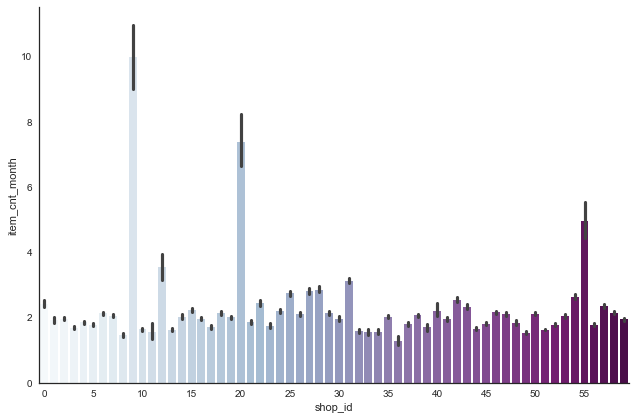

In [34]:
#item count month by shop id 
#total sales by shop :  x shops y total sales

sns.set(style="white")

g = sns.factorplot(x="shop_id",y ="item_cnt_month" , data=train, kind="bar",
                   palette="BuPu", size=6, aspect=1.5)
g.set_xticklabels(step=5)

In [35]:
a = train[['year','month','shop_id','item_cnt_month']].groupby(['year','month','shop_id']).sum().reset_index()

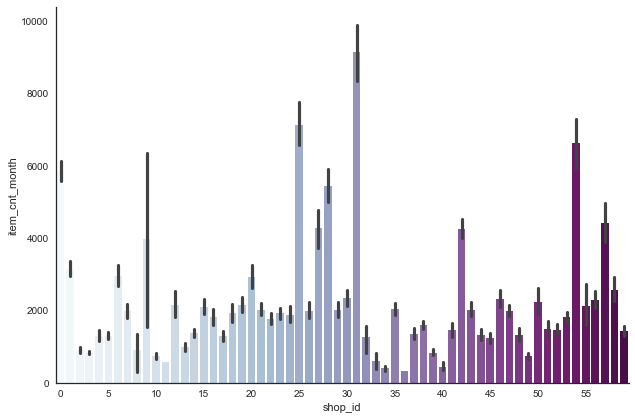

In [36]:
#item count month by shop id 
#total sales by shop :  x shops y total sales

sns.set(style="white")

g = sns.factorplot(x="shop_id",y ="item_cnt_month" , data=a, kind="bar",
                   palette="BuPu", size=6, aspect=1.5)
g.set_xticklabels(step=5)

In [37]:
a[a['shop_id']==9]

,year,month,shop_id,item_cnt_month
416,2013,10,9,6526.0
991,2014,10,9,6155.0
1286,2015,4,9,-1.0
1548,2015,10,9,3186.0


In [38]:
#item count per month for each shop id per year
b = train.groupby(['year','shop_id'])['item_cnt_month'].agg('sum').reset_index()
b.head()

,year,shop_id,item_cnt_month
0,2013,0,11705.0
1,2013,1,6311.0
2,2013,2,9961.0
3,2013,3,10199.0
4,2013,4,19002.0


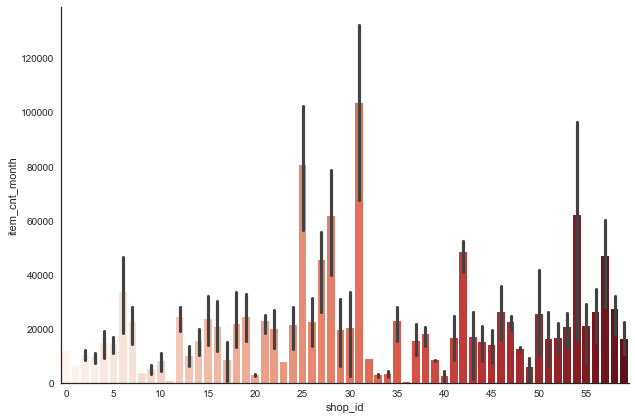

In [39]:
# variance by years 

sns.set(style="white")

g = sns.factorplot(x="shop_id",y ="item_cnt_month" , data=b, kind="bar",
                   palette="Reds", size=6, aspect=1.5)
g.set_xticklabels(step=5)

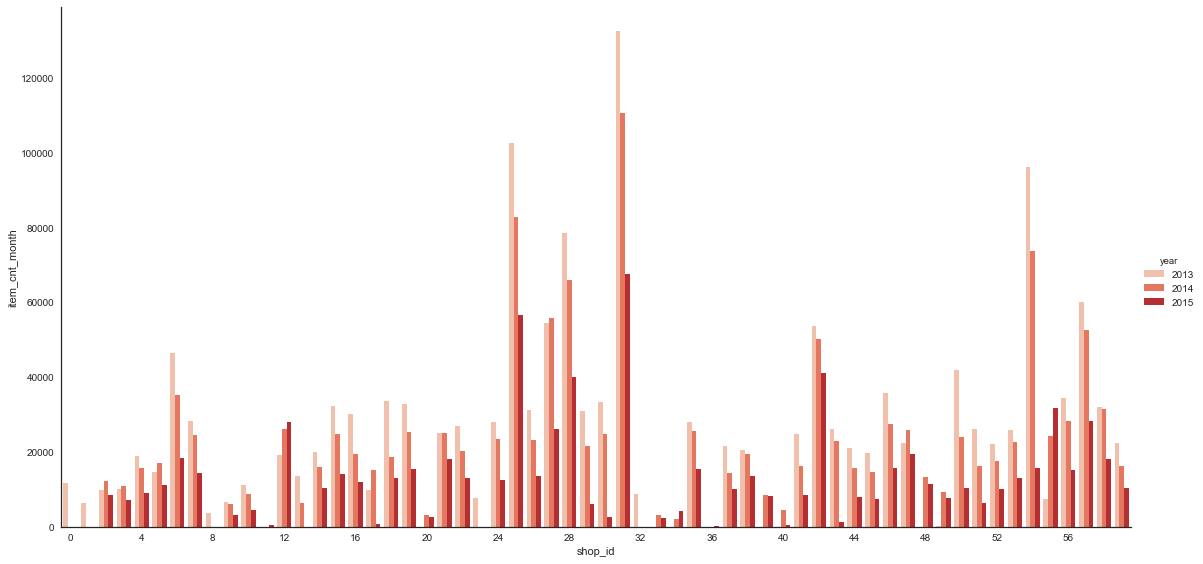

In [40]:
# for each year

sns.set(style="white")

g = sns.factorplot(x="shop_id",y ="item_cnt_month" , hue = 'year', data=b, kind="bar",
                   palette="Reds", size=8, aspect=2)
g.set_xticklabels(step=4)

In [41]:
#total sales by item and category : x item , y total sales || x category , y total sales 

#train.head()
#train.item_category_id.nunique()

c = train.groupby(['year','month','item_category_id'])['item_cnt_month'].agg('sum').reset_index()
#d = c.sort_values('item_cnt_month',ascending = False).head(100)
d = c[c['item_cnt_month']>10]

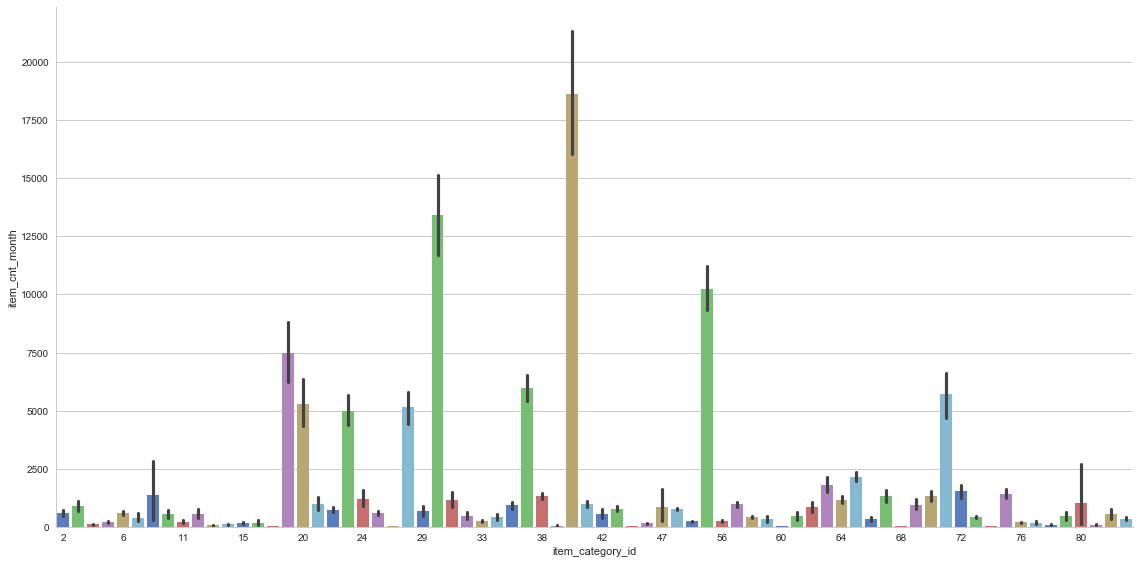

In [42]:
# variance by years 

sns.set(style="whitegrid")

g = sns.factorplot(x="item_category_id",y ="item_cnt_month" , data=d, kind="bar",
                   palette="muted", size=8, aspect=2)
g.set_xticklabels(step=4)

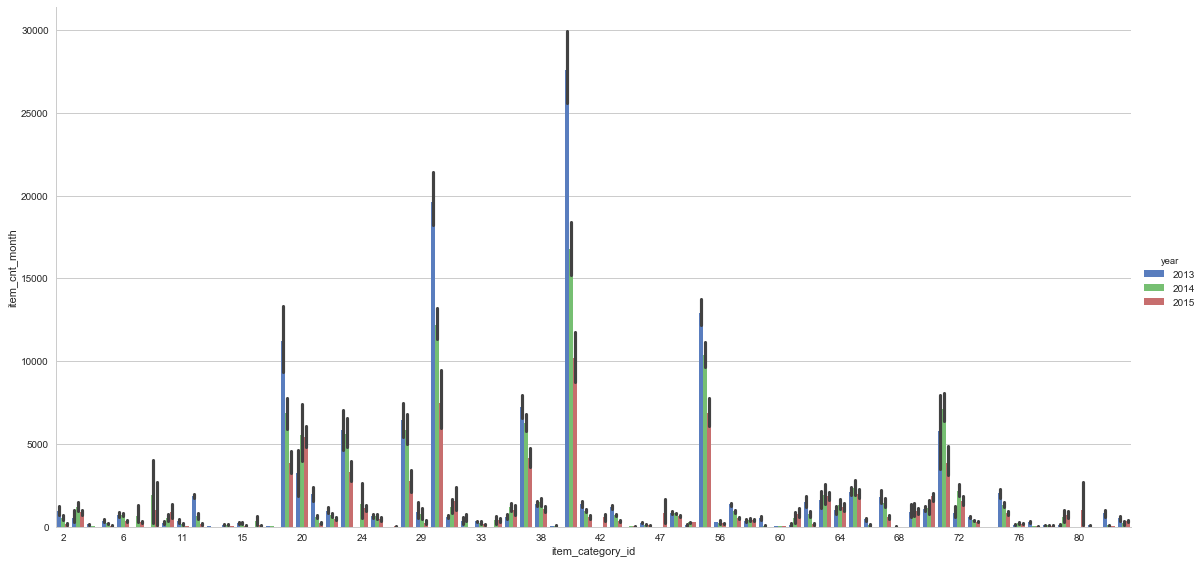

In [43]:
# each year 

sns.set(style="whitegrid")

g = sns.factorplot(x="item_category_id",y ="item_cnt_month", hue = 'year' , data=d, kind="bar",
                   palette="muted", size=8, aspect = 2 )
g.set_xticklabels(step=4)

In [44]:
# items sold per month by item category and month without respect of year

e = train.groupby(['month','item_category_id'])['item_cnt_month'].agg('sum').reset_index()
e.head()

,month,item_category_id,item_cnt_month
0,1,0,1.0
1,1,1,1.0
2,1,2,3099.0
3,1,3,3018.0
4,1,4,357.0


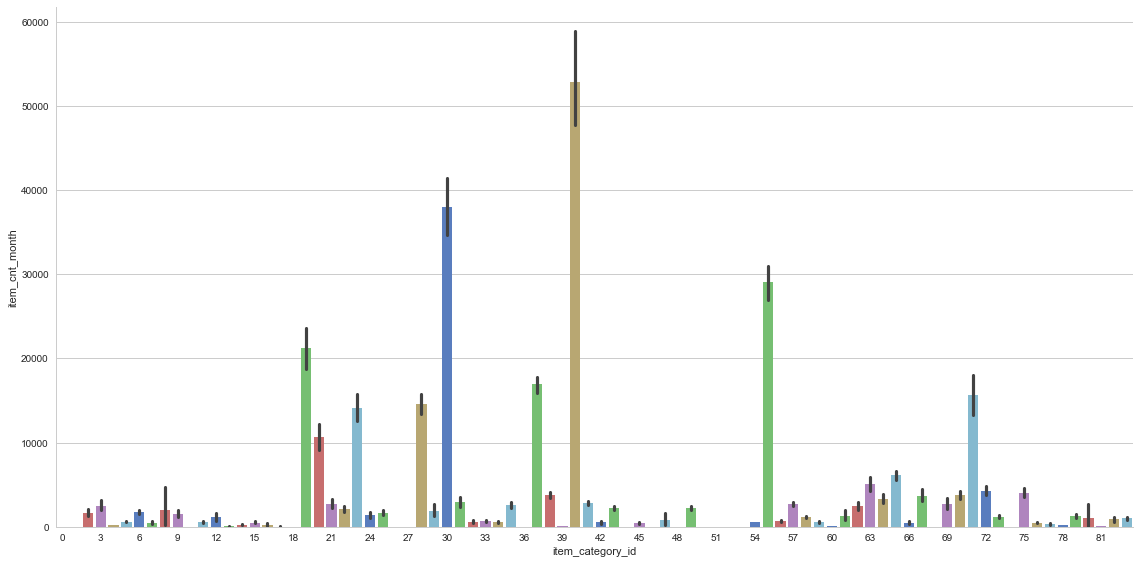

In [45]:
sns.set(style="whitegrid")

g = sns.factorplot(x="item_category_id",y ="item_cnt_month" , data=e, kind="bar",
                   palette="muted", size=8, aspect=2)
g.set_xticklabels(step=3)

In [46]:
# total sales per year / category item

w = train.groupby(['year','item_category_id'])['item_cnt_month'].agg('sum').reset_index()
w.head()

,year,item_category_id,item_cnt_month
0,2013,0,3.0
1,2013,1,2.0
2,2013,2,11339.0
3,2013,3,6588.0
4,2013,4,1897.0


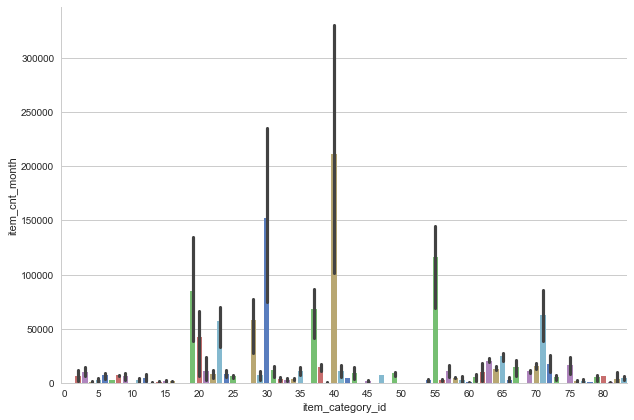

In [47]:
sns.set(style="whitegrid")

g = sns.factorplot(x="item_category_id",y ="item_cnt_month" , data=w, kind="bar",
                   palette="muted", size=6, aspect=1.5)
g.set_xticklabels(step=5)

In [48]:
# feature engineering
#shopid itemid  mean


shop_item = train[['shop_id','item_id','item_cnt_month']].groupby(['item_id','shop_id'], as_index=False)[['item_cnt_month']].mean()
shop_item = shop_item.rename(columns={'item_cnt_month':'item_cnt_total_mean'})

ww =  train.merge(shop_item,how="left",on=['shop_id','item_id'])
tt =  test.merge(shop_item,how="left",on=['shop_id','item_id'])

In [49]:
# year mean 

year_mean = train[['year','shop_id','item_id','item_cnt_month']].groupby(['year','item_id','shop_id'], as_index=False)[['item_cnt_month']].mean()
year_mean = year_mean.rename(columns={'item_cnt_month':'item_cnt_year_mean'})

ww = ww.merge(year_mean,how="left",on=['year','shop_id','item_id'])
tt['year'] = 2015
tt = tt.merge(year_mean,how="left",on=['year','shop_id','item_id'])


In [50]:
# month mean

month_mean = train[['month','shop_id','item_id','item_cnt_month']].groupby(['month','item_id','shop_id'], as_index=False)[['item_cnt_month']].mean()
month_mean = month_mean.rename(columns={'item_cnt_month':'item_cnt_monthly_mean'})

ww = ww.merge(month_mean,how="left",on=['month','shop_id','item_id'])

tt['month'] = 11
tt = tt.merge(month_mean,how="left",on=['month','shop_id','item_id'])


In [51]:
## add trend  

ww['trend'] = ww['item_cnt_month'] - ww['item_cnt_total_mean']
tt = tt.merge(ww[['shop_id','item_id','trend']],how="left",on=['shop_id','item_id'])

In [52]:
tt.head()

,year,month,shop_id,item_id,item_category_id,item_cnt_total_mean,item_cnt_year_mean,item_cnt_monthly_mean,trend
0,2015,11,5,5037,19,1.444444,1.5,1.0,-0.444444
1,2015,11,5,5037,19,1.444444,1.5,1.0,-0.444444
2,2015,11,5,5037,19,1.444444,1.5,1.0,0.555556
3,2015,11,5,5037,19,1.444444,1.5,1.0,0.555556
4,2015,11,5,5037,19,1.444444,1.5,1.0,-0.444444


In [53]:
ww.head()

,year,month,shop_id,item_id,item_cnt_month,item_category_id,item_cnt_total_mean,item_cnt_year_mean,item_cnt_monthly_mean,trend
0,2013,1,0,32,6.0,40,8.0,8.0,6.0,-2.0
1,2013,1,0,33,3.0,37,3.0,3.0,3.0,0.0
2,2013,1,0,35,1.0,40,7.5,7.5,1.0,-6.5
3,2013,1,0,43,1.0,40,1.0,1.0,1.0,0.0
4,2013,1,0,51,2.0,57,2.5,2.5,2.0,-0.5


In [54]:
#predict 
X = ww[['year','month','shop_id','item_id','item_category_id','item_cnt_total_mean','item_cnt_year_mean','item_cnt_monthly_mean','trend']]
#2.855282987239666
#X = ww[['year','month','shop_id','item_id','item_category_id','item_cnt_year_mean','item_cnt_monthly_mean']]
#3.10
#X = ww[['year','month','shop_id','item_id','item_category_id','item_cnt_monthly_mean']]
#3.35

y = ww['item_cnt_month']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17)

In [66]:
#predict 

regr = linear_model.LinearRegression()

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

score = sqrt(RMSE(y_test,y_pred))

print(score)

1.123969908431846e-13


In [71]:
ts.head()

,shop_id,item_id,date_block_num,month,year
ID,,,,,
0,5,5037,34,11,2015
1,5,5320,34,11,2015
2,5,5233,34,11,2015
3,5,5232,34,11,2015
4,5,5268,34,11,2015


In [68]:
y_pred = regr.predict(tt)


In [69]:
sample_submission.head()

,item_cnt_month
ID,
0,0.5
1,0.5
2,0.5
3,0.5
4,0.5
